Configurations

In [1]:
import sys
sys.path.append('../')
import torch
from torch import nn
from matplotlib import collections  as mc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from IPython.display import clear_output
from src.utils.cost import strong_cost
from src.model.toy_model import *
from src.utils.toy_utils import *
import os

# Divergence term
Tau = 5
divergence1 = 'balanced'
divergence2 = 'kl'


CONFIG = Config()

# GPU
CONFIG.GPU_DEVICE = 0
assert torch.cuda.is_available()
CONFIG.DEVICE = f'cuda:{CONFIG.GPU_DEVICE}'

# Training Hyps
CONFIG.NUM_EPOCHS = 30000
CONFIG.K = 2  # amount of distributions
CONFIG.LAMBDAS = [0.5,0.5]
CONFIG.DIM = 2
CONFIG.INPUT_DIM = CONFIG.DIM
CONFIG.HIDDEN_DIMS = [128,128]
CONFIG.OUTPUT_DIM_POT = 1
CONFIG.OUTPUT_DIM_MAP = CONFIG.DIM
CONFIG.LR = 1e-3
CONFIG.NUM_SAMPLES = 10_000
CONFIG.BATCH_SIZE= 1024
CONFIG.INNER_ITERATIONS = 3
CONFIG.PRIOR_MEAN = torch.tensor([5., 5.], device=CONFIG.DEVICE)
CONFIG.PRIOR_COV = 2 * torch.eye(2, device=CONFIG.DEVICE)
CONFIG.CONDITIONAL_COV = .1 * torch.eye(2, device=CONFIG.DEVICE)

Get Dataset

In [2]:
# define data
from src.data.toy_dataset import get_toydataset, ToySampler
data_name1, data_name2 = 'spiral', '8gaussian'
dataset1 = get_toydataset(data_name1, 2)
sampler1 = ToySampler(dataset1)
dataset2 = get_toydataset(data_name2, 2)
sampler2 = ToySampler(dataset2)

datas = [sampler1, sampler2]

def plot_initial_data(n):
    """
    mus - list of torch.Size([2])
    covs - list of torch.Size([2,2])
    n - int (amount of samples)
    """
    
    for idx,k in enumerate(range(CONFIG.K)):
        d = datas[k].sample([n])
        plt.scatter(d[:,0].cpu(),d[:,1].cpu(),edgecolor='black',label=f'distribution {idx+1}')
        plt.axis("equal")
        plt.grid()
        plt.legend()

plot_initial_data(2_000)

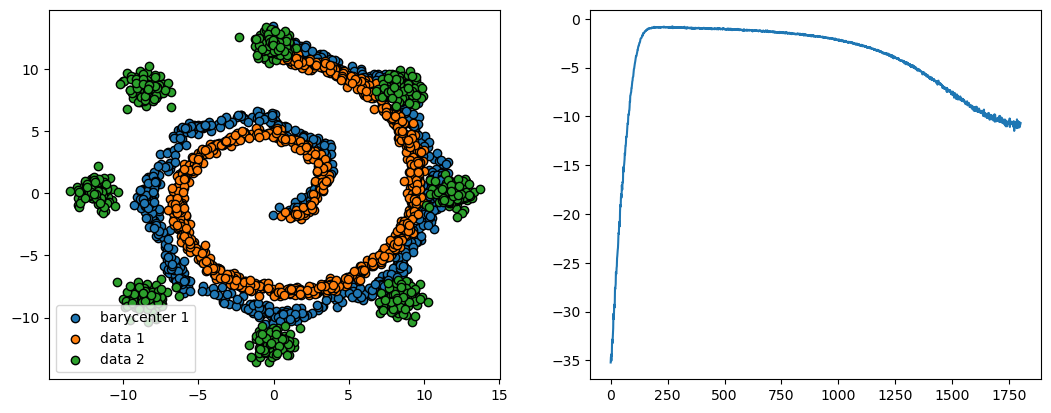

  6%|▌         | 1808/30000 [00:16<04:16, 110.05it/s]


KeyboardInterrupt: 

In [3]:
def train(
    map: OTMap, map_opt, map_sched, 
    pot: MLP, pot_opt, pot_sched,
    reg_coeff: float = 0.0, tau: float = 1.0,
    divergence1: str = 'balanced',
    divergence2: str = 'balanced',
):
    
    losses = []
    for epoch in tqdm(range(CONFIG.NUM_EPOCHS)):
        
        freeze(pot)
        unfreeze(map)
        
        #inner loop
        for it in range(CONFIG.INNER_ITERATIONS):
            for n in range(1):
                # data sampling
                data = [
                    datas[k].sample([CONFIG.BATCH_SIZE]).to(CONFIG.DEVICE)
                    for k in range(CONFIG.K)
                ]

                map_opt.zero_grad()
                loss = 0
                mapped_x, reg = map(data[0], reg=True)  # [B, N]
                cost = strong_cost(data[0], mapped_x)  # [B, 1]
                cost -= pot(mapped_x)  # [B, 1]
                cost += reg_coeff * torch.unsqueeze(reg, -1)
                cost = cost.mean(dim=0)
                loss += cost
                loss.backward()
                map_opt.step()
                map_sched.step()

        # unfreezing potentials 
        # freezing maps
        unfreeze(pot)
        freeze(map)
        
        # outer optimiztion
        pot_opt.zero_grad()
        
        loss=0
        cost = None

        # fake loss
        mapped_x, reg = map(data[0], reg=True)  # [B, N]
        
        cost = strong_cost(data[0], mapped_x)  # [B, 1]   
        cost -= pot(mapped_x)  # [B, 1]
        if divergence1 == 'kl':
            cost = - tau * (torch.exp(-cost/tau) - 1)
        elif divergence1 == 'balanced':
            pass
        cost += reg_coeff * torch.unsqueeze(reg, -1)
        cost = cost.mean(dim=0)
        loss += cost
        
        loss = -1*loss

        # real loss
        
        if divergence2 == 'kl':
            loss = loss + tau * (torch.exp(-pot(data[1])/tau) - 1).mean()
        elif divergence2 == 'balanced':
            loss = loss - pot(data[1]).mean()


        losses.append(loss.item())
        loss.backward()
        pot_opt.step()
        pot_sched.step()
        
        
        # plotting part
        if epoch % 200 ==0 :
            data = [datas[k].sample([1_000]).to(CONFIG.DEVICE)
                        for k in range(CONFIG.K)]
            
            clear_output(wait=True)
            fig, (ax, ax_l) = plt.subplots(1, 2, figsize=(12.8, 4.8))
            for k in range(CONFIG.K):
                if k == 0:
                    d = CONFIG.LAMBDAS[0] * data[k].detach().cpu() + CONFIG.LAMBDAS[1] * map(data[k]).detach().cpu()
                    ax.scatter(d[:,0],d[:,1],edgecolor='black',label=f'barycenter {k+1}')
                ax.scatter(data[k][:,0].cpu(),data[k][:,1].cpu(),edgecolor='black',label=f'data {k+1}')
                ax.grid()
                ax.legend()
                # ax.set_xlim(-8, 8)
                # ax.set_ylim(-8, 8)
                
            ax_l.plot(losses)
            plt.show()

seed_everything(0, avoid_benchmark_noise=True)

map = DeterministicMap(CONFIG.INPUT_DIM, CONFIG.HIDDEN_DIMS, CONFIG.OUTPUT_DIM_MAP).to(CONFIG.DEVICE)
map_opt, map_sched = get_opt_sched(map, CONFIG.LR, CONFIG.NUM_EPOCHS * CONFIG.INNER_ITERATIONS)

pot = MLP(CONFIG.INPUT_DIM,
        *CONFIG.HIDDEN_DIMS,
        CONFIG.OUTPUT_DIM_POT).to(CONFIG.DEVICE)
pot_opt, pot_sched = get_opt_sched(pot, CONFIG.LR, CONFIG.NUM_EPOCHS)


train(map, map_opt, map_sched, 
      pot, pot_opt, pot_sched, 
      tau=Tau, divergence1=divergence1, divergence2=divergence2)

Visualize

In [ ]:
print('Tau=%d'%Tau)
data = [datas[k].sample([2000]).to(CONFIG.DEVICE) for k in range(CONFIG.K)]

TRAINED_BARYCENTERS = {}

clear_output(wait=True)
fig, (ax, ax_l) = plt.subplots(1, 2, figsize=(12.8, 4.8))

if divergence1 == 'balanced':
    acc = data[0]

elif divergence1 == 'kl':
    U = torch.rand(len(data[0]))
    mapped_x, _ = map(data[0], reg=True)  # [B, N]
    f_c = strong_cost(data[0], mapped_x)  # [B, 1]
    f_c -= pot(mapped_x)
        
    c = torch.max(torch.exp(-f_c/Tau)).cpu()
    acc = data[0][U < 1/c * torch.exp(-f_c/Tau).flatten().detach().cpu()]
    rej = data[0][U >= 1/c * torch.exp(-f_c/Tau).flatten().detach().cpu()]
    
mapped_x_acc, _ = map(acc, reg=True)
mapped_x_acc = (CONFIG.LAMBDAS[0] * acc + CONFIG.LAMBDAS[1] * mapped_x_acc) / sum(CONFIG.LAMBDAS)
    
TRAINED_BARYCENTERS[f'mu_0'] = acc.detach().cpu().numpy()
TRAINED_BARYCENTERS[f'barycenter_0'] = mapped_x_acc.detach().cpu().numpy()

ax.scatter(data[0][:,0].cpu(),data[0][:,1].cpu(), edgecolor='black',label=f'data 1')
ax.scatter(acc[:,0].cpu(),acc[:,1].cpu(),color='black',edgecolor='black',label=f'accepted 1')
# ax.scatter(rej[:,0].cpu(),rej[:,1].cpu(),color='white',edgecolor='black',label=f'accepted 1')
# if k==0:
lines =  list(zip(acc[:64].cpu().numpy(), mapped_x_acc[:64].cpu().numpy()))
lc = mc.LineCollection(lines, linewidths=0.5, color='white', zorder=4)
ax.scatter(mapped_x_acc[:,0].cpu().detach(), mapped_x_acc[:,1].cpu().detach(), edgecolor='black',label=f'barycenter 1')

ax.scatter(data[1][:,0].cpu().detach(),data[1][:,1].cpu().detach(), edgecolor='black',label=f'data 2')
ax.add_collection(lc)
ax.grid()
ax.legend()
# ax.set_xlim(-8, 8)
# ax.set_ylim(-8, 8)

plt.show()

Evaluation

In [ ]:
import ot
# discrete POT
print('Tau=%d'%Tau)

data = [data[k].detach().cpu() for k in range(CONFIG.K)]
M = (data[0][:, None, :] - data[1][None, :, :]).pow(2).sum(2).mul(0.5)

uniform1 = torch.ones(len(data[0])) / len(data[0])
uniform2 = torch.ones(len(data[1])) / len(data[1])

if divergence1 == 'balanced' and divergence2 == 'balanced': NotImplementedError
if divergence1 == 'balanced': reg_m = (100, Tau)
elif divergence2 == 'balanced': reg_m = (Tau, 100)

kl_uot = ot.unbalanced.mm_unbalanced(uniform1, uniform2, M, reg_m, div='kl')

In [ ]:
if kl_uot.sum() > 0:
    P = kl_uot / kl_uot.max()
data_np = [samples.detach().cpu().numpy() for samples in data]

if divergence1 == 'balanced':
    idx = kl_uot.argmax(1)
    BARYCENTERS = {}
    BARYCENTERS['mu_0'] = data[0].detach().cpu().numpy()
    BARYCENTERS['mu_1'] = data[1][idx].detach().cpu().numpy()
    BARYCENTERS['barycenter'] = (CONFIG.LAMBDAS[0] * BARYCENTERS['mu_0'] + CONFIG.LAMBDAS[1] * BARYCENTERS['mu_1']) / sum(CONFIG.LAMBDAS)

elif divergence1 == 'kl':
    if kl_uot.sum() > 0:
        P = kl_uot / kl_uot.max()

    data_np = [samples.detach().cpu().numpy() for samples in data]
    U = torch.rand_like(P)
    Q = 1*(U<P)

    BARYCENTERS = {'mu_0': [], 'barycenter': [], 'mu_1': []}
    for i in range(len(data_np[0])):
        for j in range(len(data_np[1])):
            if Q[i, j] > 0:
                barycenter = (CONFIG.LAMBDAS[0] * data_np[0][i] + CONFIG.LAMBDAS[1] * data_np[1][j]) / sum(CONFIG.LAMBDAS)
                BARYCENTERS['mu_0'].append(data_np[0][i])
                BARYCENTERS['barycenter'].append(barycenter)
                BARYCENTERS['mu_1'].append(data_np[1][j])
                plt.plot([data_np[0][i, 0], data_np[1][j, 0]], [data_np[0][i, 1], data_np[1][j, 1]], color='C2', alpha=Q[i, j].detach().cpu().numpy() * 0.3)
                plt.scatter(barycenter[0], barycenter[1], color='C3')

    for key, item in BARYCENTERS.items():
        BARYCENTERS[key] = np.stack(item)

In [ ]:
# Measurement 1: Accepted Samples for source and target (W2)
for k in range(1):
    fake, real = TRAINED_BARYCENTERS[f'mu_{k}'], BARYCENTERS[f'mu_{k}']
    u1, u2 = np.ones(len(fake)) / len(fake), np.ones(len(real)) / len(real)
    M = 0.5 * np.sum((fake[:,np.newaxis,:] - real[np.newaxis,:,:])**2, axis=2)
    print(f'W2 distance between Accepted mu_{k}: {ot.emd2(u1, u2, M)}')


# Measurement 2: Integral L2 of real and learned transport maps w.r.t. Accepted samples from real
with torch.no_grad():
    for k in range(1):
        source = torch.tensor(BARYCENTERS[f'mu_{k}']).float().to(CONFIG.DEVICE)
        barycenter = map(source).detach().cpu().numpy()
        print(f'L2 dist of T_{k} and T_{k}_real:', ((BARYCENTERS['barycenter'] - barycenter)**2).sum(1).mean())


# Measurement 3: Distance between barycenters
for k in range(1):
    fake, real = TRAINED_BARYCENTERS[f'barycenter_{k}'], BARYCENTERS['barycenter']
    u1, u2 = np.ones(len(fake)) / len(fake), np.ones(len(real)) / len(real)
    M = 0.5 * np.sum((fake[:,np.newaxis,:] - real[np.newaxis,:,:])**2, axis=2)
    print(f'W2 distance between Barycenters {k}: {ot.emd2(u1, u2, M)}')

In [ ]:
# save transport maps
parent = f'ckpts/COMPARISONS_{data_name1}_{data_name2}_Tau{Tau}'
EXP_DIR = os.path.join(parent, f'UOTM')
os.makedirs(EXP_DIR, exist_ok=True)
torch.save(map.state_dict(), os.path.join(EXP_DIR, f'net0_epoch_{CONFIG.NUM_EPOCHS}.pth'))